In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# load help packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # additional plotting functionality

# Input data files are available in the "../input/" directory.
# For example, running the below code (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras


['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


Using TensorFlow backend.


In [2]:
# load data
xray_data = pd.read_csv('../input/Data_Entry_2017.csv')

# see how many observations there are
num_obs = len(xray_data)
print('Number of observations:',num_obs)

# examine the raw data before performing pre-processing
xray_data.head(5) # view first 5 rows
#xray_data.sample(5) # view 5 randomly sampled rows

Number of observations: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
from glob import glob
#import os # already imported earlier

my_glob = glob('../input/images*/images/*.png')
print('Number of Observations: ', len(my_glob)) # check to make sure I've captured every pathway, should equal 112,120

Number of Observations:  112120


In [4]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)


In [5]:
num_unique_labels = xray_data['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels)

# let's look at the label distribution to better plan our next step
count_per_unique_label = xray_data['Finding Labels'].value_counts() # get frequency counts per label
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes


Number of unique labels: 836


In [6]:
print(df_count_per_unique_label) # view tabular results

                                                    Finding Labels
No Finding                                                   60361
Infiltration                                                  9547
Atelectasis                                                   4215
Effusion                                                      3955
Nodule                                                        2705
Pneumothorax                                                  2194
Mass                                                          2139
Effusion|Infiltration                                         1603
Atelectasis|Infiltration                                      1350
Consolidation                                                 1310
Atelectasis|Effusion                                          1165
Pleural_Thickening                                            1126
Cardiomegaly                                                  1093
Emphysema                                                     

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

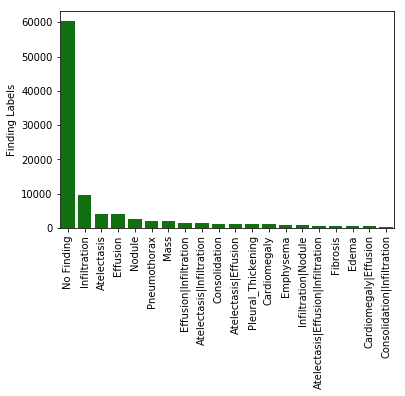

In [7]:
sns.barplot(x = df_count_per_unique_label.index[:20], y="Finding Labels", data=df_count_per_unique_label[:20], color = "green")
plt.xticks(rotation = 90) 

In [8]:
# define dummy labels for one hot encoding - simplifying to 14 primary classes (excl. No Finding)
dummy_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# One Hot Encoding of Finding Labels to dummy_labels
for label in dummy_labels:
    xray_data[label] = xray_data['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
xray_data.head(20) # check the data, looking good!

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,full_path,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000003_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN,../input/images_001/images/00000003_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN,../input/images_001/images/00000003_003.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000003_004.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN,../input/images_001/images/00000003_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Infiltration          19894.0
Effusion              13317.0
Atelectasis           11559.0
Nodule                 6331.0
Mass                   5782.0
Pneumothorax           5302.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2776.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1431.0
Hernia                  227.0
dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x7ffa5bf07048>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
  <a list of 14 Text xticklabel objects>))

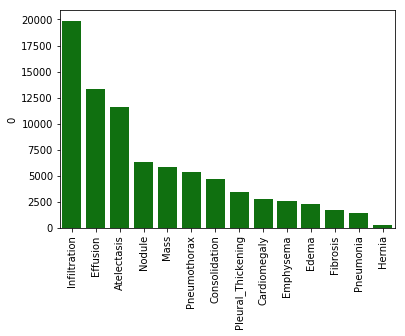

In [9]:
clean_labels = xray_data[dummy_labels].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [10]:
## MODEL CREATION PHASE STARTS HERE

# create vector as ground-truth, will use as actuals to compare against our predictions later
xray_data['target_vector'] = xray_data.apply(lambda target: [target[dummy_labels].values], 1).map(lambda target: target[0])

In [11]:
xray_data.head() 

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,full_path,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,target_vector
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
# split the data into a training and testing set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(xray_data, test_size = 0.2, random_state = 1993)

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_set))
print('test set - # of observations): ', len(test_set))
print('prior, full data set - # of observations): ', len(xray_data))

training set - # of observations:  89696
test set - # of observations):  22424
prior, full data set - # of observations):  112120


In [13]:
#Data Augmentation 

from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

In [14]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [15]:
image_size = (128, 128) # image re-sizing target

train_gen = flow_from_dataframe(data_gen, train_set, path_col = 'full_path', y_col = 'target_vector', 
                                target_size = image_size, 
                                color_mode = 'rgb',
                                batch_size = 32)

valid_gen = flow_from_dataframe(data_gen, test_set, path_col = 'full_path', y_col = 'target_vector', 
                                target_size = image_size, 
                                color_mode = 'rgb', 
                                batch_size = 128)

# define test sets
test_X, test_Y = next(flow_from_dataframe(data_gen, test_set, path_col = 'full_path', y_col = 'target_vector', 
                                          target_size = image_size, 
                                          color_mode = 'rgb', 
                                          batch_size = 2048))

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 89696 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 22424 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 22424 images


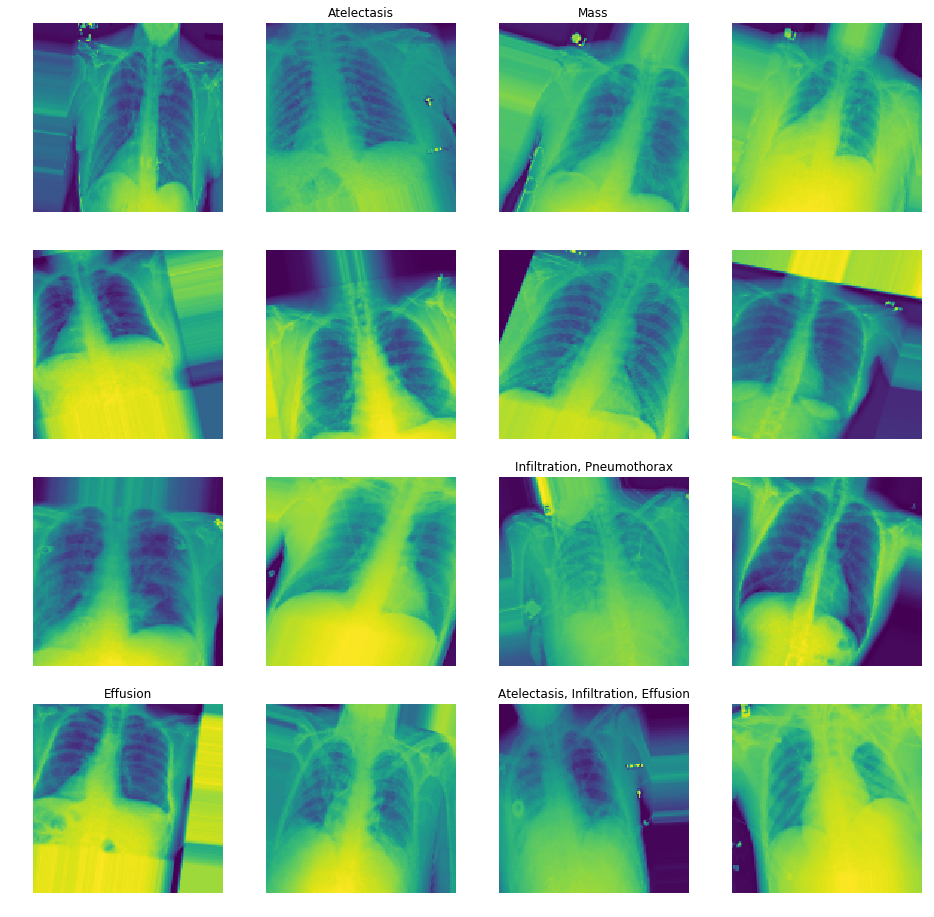

In [16]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(dummy_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')


# **DenseNet Model Training**

In [17]:
# DenseNet model
from keras.applications.densenet import DenseNet121, preprocess_input
img_in = Input(t_x.shape[1:])              #input of model 
DenseNet_model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 

x = DenseNet_model.output  
predictions = Dense(len(dummy_labels), activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
DenseNet_model = Model(inputs=img_in, outputs=predictions)

29089792/29084464 [==============================] - 2s 0us/step


In [18]:
#Learning rate & loss specified in Base paper
optimizer = Adam(lr=0.001)
DenseNet_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

In [19]:
# set up a checkpoint for model training
# https://keras.io/callbacks/
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only = True)
callbacks_list = [checkpointer]

In [20]:
#Epochs from Base Paper && Best value of Steps per epoch is other papers
history = DenseNet_model.fit_generator(train_gen, 
                                  steps_per_epoch=128,
                                  validation_data = (test_X, test_Y), callbacks = callbacks_list,
                                  epochs = 10)

Epoch 1/10
128/128 [==============================] - 145s 1s/step - loss: 0.2133 - binary_accuracy: 0.9346 - val_loss: 0.2303 - val_binary_accuracy: 0.9387

Epoch 00001: val_loss improved from inf to 0.23026, saving model to weights.best.01-0.23.hdf5
Epoch 2/10
128/128 [==============================] - 113s 885ms/step - loss: 0.1837 - binary_accuracy: 0.9471 - val_loss: 0.2135 - val_binary_accuracy: 0.9428

Epoch 00002: val_loss improved from 0.23026 to 0.21352, saving model to weights.best.02-0.21.hdf5
Epoch 3/10
128/128 [==============================] - 119s 930ms/step - loss: 0.1789 - binary_accuracy: 0.9489 - val_loss: 0.1910 - val_binary_accuracy: 0.9488

Epoch 00003: val_loss improved from 0.21352 to 0.19099, saving model to weights.best.03-0.19.hdf5
Epoch 4/10
128/128 [==============================] - 119s 933ms/step - loss: 0.1769 - binary_accuracy: 0.9494 - val_loss: 0.3403 - val_binary_accuracy: 0.9255

Epoch 00004: val_loss did not improve from 0.19099
Epoch 5/10
128/128

In [21]:
DenseNet_model.save('denseNet.h5')

In [22]:
from keras.models import load_model 
DenseNet_multi_disease = load_model('denseNet.h5')

In [23]:
test_X.shape

(2048, 128, 128, 3)

In [24]:
sample_image = test_X[0]

In [25]:
sample_image = sample_image.reshape((1, 128,128,3))

In [26]:
DenseNet_model.predict(sample_image)

array([[0.09416283, 0.0636316 , 0.10632697, 0.05126978, 0.0052087 ,
        0.02265523, 0.04411643, 0.1287648 , 0.00778517, 0.04585589,
        0.02761202, 0.10173941, 0.14797205, 0.00197646]], dtype=float32)

In [27]:
y_pred = DenseNet_model.predict(test_X)

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y.astype(int), y_pred)

0.6181749920965481

In [29]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

NameError: name 'model' is not defined

In [ ]:
history = model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), callbacks = callbacks_list,
                                  epochs = 5)

In [ ]:
y_pred = model.predict(test_X, batch_size = 64, verbose = 1)

In [ ]:
roc_auc_score(test_Y.astype(int), y_pred)

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

In [ ]:
history = model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), callbacks = callbacks_list,
                                  epochs = 5)

In [ ]:
y_pred = model.predict(test_X, batch_size = 64, verbose = 1)

In [ ]:
roc_auc_score(test_Y.astype(int), y_pred)

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

In [ ]:
history = model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), callbacks = callbacks_list,
                                  epochs = 5)

In [ ]:
y_pred = model.predict(test_X, batch_size = 64, verbose = 1)

In [ ]:
roc_auc_score(test_Y.astype(int), y_pred)